<a href="https://colab.research.google.com/github/dikshetha/Basic-ML/blob/main/Amazon_Book_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***Overview:***

With the rapid growth of data collection, more efficient systems are created based on the big data. Recommendation system is one of information filtering systems which could improve the quality of search results and provide items that are more relevant to the search item or are related to the search history of the user. Almost every major tech company has applied recommendation systems in some form or the other: YouTube uses it to decide which video to play next on autoplay; Spotify uses it to provide users "Made For You" daily mixes etc.

In terms of this project, we try to learn from data and recommend best books to users, based on self & others behaviour.

# Ingest

This dataset contains book reviews from Amazon, with below columns:

*  User ID
*  Book ID
*  Rating (1 to 5)
*  Date they gave the ratings(timestamp unix)

Because of the huge data size, the ratings_Books_sample.csv is the dataset sampled from the original dataset with 200K records.

Data source: http://jmcauley.ucsd.edu/data/amazon/index.html

In [ ]:
import pandas as pd
import numpy as np
import math
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!pip install -q scikit-surprise

In [ ]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader, evaluate

In [ ]:
df = pd.read_csv("/content/gdrive/My Drive/MachineLearning/ratings_Books_sample.csv")

In [ ]:
df.head()

,Unnamed: 0,user,item,rating,timestamp
0,10994572,A000023026XVLM97BM7KY,0957544901,4.0,1397865600
1,9234850,A00003322NZ9C82Y46DFN,0786903945,5.0,1403740800
2,15461852,A0000440NYTE2D2YB089,1492111619,5.0,1380153600
3,9362165,A00005181SC9PSCD58LCG,0800720024,5.0,1400025600
4,8608310,A00005181SC9PSCD58LCG,076278038X,4.0,1389571200


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 5 columns):
Unnamed: 0    200000 non-null int64
user          200000 non-null object
item          200000 non-null object
rating        200000 non-null float64
timestamp     200000 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 7.6+ MB


In [ ]:
df.drop(df.columns[0],axis=1,inplace=True)

# EDA

In [ ]:
p = df.groupby('rating')['rating'].agg(['count'])
p

,count
rating,
1.0,9427
2.0,8322
3.0,16796
4.0,41676
5.0,123779


In [ ]:
item_count = df["item"].nunique()
user_count = df['user'].nunique()
rating_count = df["rating"].count()

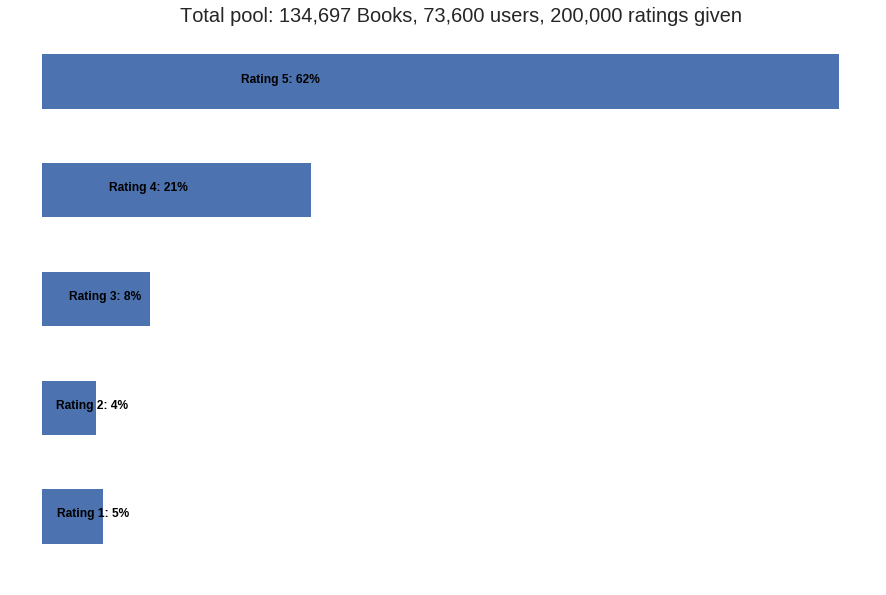

In [ ]:
ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Books, {:,} users, {:,} ratings given'.format(item_count, user_count, rating_count), fontsize=20)
plt.axis('off')
          
for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'black', weight = 'bold')

The above bar chart gives us a first look on how the data spread. We can see that the rating tends to be relatively positive (83% of the ratings > = 4), which may be due to the fact that unhappy readers tend to just leave instead of making efforts to rate. As a result, it indicates that low rating books are generally very bad.

# Model

### Data slicing

To improve the data quality, the following two steps are done

*   Remove books with too less reviews (they are relatively not popular)
*   Remove users who give too less reviews (they are relatively less active)



In [ ]:
f = ['count','mean']

df_book_summary = df.groupby('item')['rating'].agg(f)
book_benchmark = round(df_book_summary['count'].quantile(0.8),0)
drop_book_list = df_book_summary[df_book_summary['count'] < book_benchmark].index

print('Book minimum times of review: {}'.format(book_benchmark))

df_user_summary = df.groupby('user')['rating'].agg(f)
user_benchmark = round(df_user_summary['count'].quantile(0.8),0)
drop_user_list = df_user_summary[df_user_summary['count'] < user_benchmark].index

print('User minimum times of review: {}'.format(user_benchmark))

Book minimum times of review: 1.0
User minimum times of review: 3.0


After trimming down the data, the difference in data size is as follows.

In [ ]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['item'].isin(drop_book_list)]
df = df[~df['user'].isin(drop_user_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::20000, :])

Original Shape: (200000, 4)
After Trim Shape: (130075, 4)
-Data Examples-
                         user        item  rating   timestamp
3       A00005181SC9PSCD58LCG  0800720024     5.0  1400025600
32740          A102ZFBCV9QVOA  0030648130     5.0  1389571200
63238           A109O4KY7L1FZ  1455546925     5.0  1378598400
93508          A10GDA5I0MM0AI  B00BWBKG3C     5.0  1365984000
124654         A10NMCFY76RY4F  1933926252     2.0  1367107200
155442          A10UK4UFQ6XV3  0062336592     5.0  1397952000
184937         A110OR35N5WNWF  1612356087     3.0  1378425600


### Recommendation with Collaborative Filtering

This project utilizes collaborative filtering, a system matching persons with similar interests and providing recommendations based on this matching. Collaborative filters do not require item metadata like its content-based counterparts. 

Surprise library is utilized here to implement SVD.

In [ ]:
reader = Reader()

data = Dataset.load_from_df(df[['user', 'item', 'rating']], reader)
data.split(n_folds=3)

svd = SVD()
evaluate(svd, data, measures=['RMSE', 'MAE'])

/usr/local/lib/python3.6/dist-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/usr/local/lib/python3.6/dist-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.9913
MAE:  0.7506
------------
Fold 2
RMSE: 0.9944
MAE:  0.7498
------------
Fold 3
RMSE: 0.9978
MAE:  0.7530
------------
------------
Mean RMSE: 0.9945
Mean MAE : 0.7511
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'mae': [0.7505826698862714,
                             0.7497814022119256,
                             0.7529664730794076],
                            'rmse': [0.9913094496844685,
                             0.9943952618896811,
                             0.9978152075679302]})

We get a mean Root Mean Square Error of 0.99 approx.

Let us now train on our dataset and arrive at predictions.

In [ ]:
trainset = data.build_full_trainset()
svd.fit(trainset)

Below is what user A00006923FEAFJLE7GHEL liked in the past:

In [ ]:
df[(df['user'] == "A00006923FEAFJLE7GHEL") & (df["rating"] == 5)]

,user,item,rating,timestamp
7,A00006923FEAFJLE7GHEL,1451661215,5.0,1353110400
8,A00006923FEAFJLE7GHEL,0345803493,5.0,1353110400
9,A00006923FEAFJLE7GHEL,0345803507,5.0,1353110400


We could use the code below to estimate user A00006923FEAFJLE7GHEL's rating on a specific book in the dataset.

In [ ]:
svd.predict("A00006923FEAFJLE7GHEL", 1451661215).est

4.445117255085559

In [ ]:
#unique book id in the dataset
df_title = pd.Series(df["item"]).unique()
df_title = pd.DataFrame(df_title, columns=['Books']) 
df_title.head()

,Books
0,0800720024
1,076278038X
2,0062023144
3,1451661215
4,0345803493


Let's predict which books user A00006923FEAFJLE7GHEL would love to read:

In [ ]:
user_A00006923FEAFJLE7GHEL = df_title.copy()
user_A00006923FEAFJLE7GHEL = user_A00006923FEAFJLE7GHEL.reset_index()
user_A00006923FEAFJLE7GHEL = user_A00006923FEAFJLE7GHEL[~user_A00006923FEAFJLE7GHEL['Books'].isin(drop_book_list)]

svd.train(trainset)

user_A00006923FEAFJLE7GHEL['Estimate_Score'] = user_A00006923FEAFJLE7GHEL['Books'].apply(lambda x: svd.predict("A00006923FEAFJLE7GHEL", x).est)

user_A00006923FEAFJLE7GHEL = user_A00006923FEAFJLE7GHEL.sort_values('Estimate_Score', ascending=False)
print(user_A00006923FEAFJLE7GHEL.head(10))

/usr/local/lib/python3.6/dist-packages/surprise/prediction_algorithms/algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)


       index       Books  Estimate_Score
4437    4437  1410440478        5.000000
226      226  0307730697        5.000000
4444    4444  0307743659        5.000000
827      827  0615680046        4.996404
4944    4944  1442366680        4.993126
9535    9535  0385302320        4.989260
228      228  0671027034        4.988436
12424  12424  0375725601        4.986919
10223  10223  1565129164        4.985027
1097    1097  0439136350        4.978488


# Conclusion


Based on Amazon book reviews data, Surprise library is utilized here to implement SVD and such recommendation system could estimate book ratings for a specific user and recommend 10 books a user would love to read which have the highest estimated rating.

However, one of the limitations of this project comes from the sampled Amazon book review data. Because the original dataset is too big, I just sampled 200K records from it. As a result, there are a large number of books which do not have many reviews. (Remember although I have removed books with too less reviews using 0.8 quantile, the book minimum times of review are still 1.) The data quality would influence the accuracy and efficiency of the recommendation system to some degree.  If we could find a dataset within which each book has many reviews and each user rates many books, the model could be expected to be better. In addition, the dataset only has book id but does not have the corresponding book names, which limits the insights we could get from the recommendation results.

